In [27]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CSE-156/Analysis Study'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CSE-156/Analysis Study


In [28]:
# install necessary libraries
!pip install transformers datasets pipeline
!pip install -U sentence-transformers

In [29]:
# import libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import math
from tqdm import tqdm

In [30]:
# read squad v2 results file (includes original data)
file_dir = '/content/drive/My Drive/{}/squad_v2_pred.csv'.format(FOLDERNAME)
squad_v2_df = pd.read_csv(file_dir)
squad_v2_df

,id,title,context,question,answers,prediction
0,570d2417fed7b91900d45c3e,Victoria_(Australia),The economy of Victoria is highly diversified:...,Where according to gross state product does Vi...,"{'text': array(['second', 'second', 'second'],...",second
1,572864542ca10214002da2e1,University_of_Chicago,The Maroons compete in the NCAA's Division III...,What player first won the Heisman Trophy for t...,"{'text': array(['Jay Berwanger', 'Jay Berwange...",Jay Berwanger
2,5ad15289645df0001a2d175d,European_Union_law,Free movement of goods within the European Uni...,What were states not responsible for in Articl...,"{'text': array([], dtype=object), 'answer_star...",NaN
3,5a668fc9f038b7001ab0bfe6,Packet_switching,"Merit Network, Inc., an independent non-profit...",After the University of Ann Arbor and Wayne St...,"{'text': array([], dtype=object), 'answer_star...",NaN
4,5730035e04bcaa1900d77004,Islamism,Roughly contemporaneous with Maududi was the f...,The motto of the Muslim Brotherhood specifies ...,"{'text': array([""the Qur'an"", ""the Qur'an"", ""Q...",the Qur'an
...,...,...,...,...,...,...
11868,57264cfa708984140094c1c5,Ctenophora,The outer surface bears usually eight comb row...,What does the 9 +3 pattern of cilia thought to...,"{'text': array(['supporting function', 'suspec...",What does the 9 +3 pattern of cilia thought to...
11869,5a82370631013a001a3352e2,Harvard_University,"Harvard operates several arts, cultural, and s...",How many museums does the Busch-Reisinger Muse...,"{'text': array([], dtype=object), 'answer_star...",NaN
11870,5ad4a75aba00c4001a268eea,Immune_system,Microorganisms or toxins that successfully ent...,What kind of cells fail to send out alarm sign...,"{'text': array([], dtype=object), 'answer_star...",NaN
11871,57378b141c4567190057449f,Force,"Since then, and so far, general relativity has...",What theory best explains gravity?,"{'text': array(['general relativity', 'general...",general relativity


In [31]:
# clean up answers columns -> convert back to list of strings, clean up whitespace in predictions
for index, row in squad_v2_df.iterrows():
  text = row['answers']

  # remove all extra characters
  text = text.replace("\n", "")
  text = text.replace('"', '')
  text = text.replace("'", '')

  # get list of answers as a string
  start = text.index('[')
  end = text.index(']')
  list_string = text[start:end+1]

  # convert to actual list
  actual_list = list_string.strip("[]").split(', ')
  actual_list = [answer.strip() for answer in actual_list] # remove leading/trailing whitespace
  row['answers'] = actual_list

  # clean whitespace off of predictions
  if isinstance(row['prediction'], str):
    row['prediction'] = row['prediction'].strip()

In [32]:
squad_v2_df

,id,title,context,question,answers,prediction
0,570d2417fed7b91900d45c3e,Victoria_(Australia),The economy of Victoria is highly diversified:...,Where according to gross state product does Vi...,"[second, second, second]",second
1,572864542ca10214002da2e1,University_of_Chicago,The Maroons compete in the NCAA's Division III...,What player first won the Heisman Trophy for t...,"[Jay Berwanger, Jay Berwanger, Jay Berwanger]",Jay Berwanger
2,5ad15289645df0001a2d175d,European_Union_law,Free movement of goods within the European Uni...,What were states not responsible for in Articl...,[],NaN
3,5a668fc9f038b7001ab0bfe6,Packet_switching,"Merit Network, Inc., an independent non-profit...",After the University of Ann Arbor and Wayne St...,[],NaN
4,5730035e04bcaa1900d77004,Islamism,Roughly contemporaneous with Maududi was the f...,The motto of the Muslim Brotherhood specifies ...,"[the Quran, the Quran, Quran]",the Qur'an
...,...,...,...,...,...,...
11868,57264cfa708984140094c1c5,Ctenophora,The outer surface bears usually eight comb row...,What does the 9 +3 pattern of cilia thought to...,"[supporting function, suspected to have a supp...",What does the 9 +3 pattern of cilia thought to...
11869,5a82370631013a001a3352e2,Harvard_University,"Harvard operates several arts, cultural, and s...",How many museums does the Busch-Reisinger Muse...,[],NaN
11870,5ad4a75aba00c4001a268eea,Immune_system,Microorganisms or toxins that successfully ent...,What kind of cells fail to send out alarm sign...,[],NaN
11871,57378b141c4567190057449f,Force,"Since then, and so far, general relativity has...",What theory best explains gravity?,"[general relativity, general relativity, gener...",general relativity


In [33]:
# basic statistics
print(f"Number of entries: {squad_v2_df.shape[0]}")
print(f"Columns: {squad_v2_df.columns}")

titles = squad_v2_df['title'].unique()
print(f"\nGroups ({len(titles)}): {titles}")

avg_context_length = (squad_v2_df['context'].apply(len)).mean()
print(f"\nAverage length of context text (characters): {avg_context_length:.2f}")

Number of entries: 11873
Columns: Index(['id', 'title', 'context', 'question', 'answers', 'prediction'], dtype='object')

Groups (35): ['Victoria_(Australia)' 'University_of_Chicago' 'European_Union_law'
 'Packet_switching' 'Islamism' 'Amazon_rainforest' 'Force' 'Construction'
 'Scottish_Parliament' 'Computational_complexity_theory' 'Rhine'
 'Fresno,_California' '1973_oil_crisis' 'Economic_inequality'
 'Southern_California' 'Steam_engine' 'Huguenot' 'Civil_disobedience'
 'Oxygen' 'Intergovernmental_Panel_on_Climate_Change' 'Ctenophora'
 'Private_school' 'Warsaw' 'Immune_system' 'Imperialism'
 'French_and_Indian_War' 'Yuan_dynasty' 'Pharmacy' 'Geology'
 'Harvard_University' 'Sky_(United_Kingdom)' 'Prime_number' 'Normans'
 'Black_Death' 'Jacksonville,_Florida']

Average length of context text (characters): 810.97


In [34]:
def empty_answers(row):
  if row['answers'][0] == '':
    return True
  return False

# extract out the adverserial examples
adverserial_examples = squad_v2_df[squad_v2_df.apply(empty_answers, axis=1)]
adverserial_examples

,id,title,context,question,answers,prediction
2,5ad15289645df0001a2d175d,European_Union_law,Free movement of goods within the European Uni...,What were states not responsible for in Articl...,[],NaN
3,5a668fc9f038b7001ab0bfe6,Packet_switching,"Merit Network, Inc., an independent non-profit...",After the University of Ann Arbor and Wayne St...,[],NaN
7,5a25e4a2ef59cd001a623d0e,Construction,A construction project is a complex net of con...,What do bad time elements lead to?,[],NaN
8,5ad0291f77cf76001a686c2a,Scottish_Parliament,"In addition to the General Assembly Hall, the ...",What was originally built as headquarters of t...,[],NaN
9,5ad5719f5b96ef001a10aeef,Computational_complexity_theory,Earlier papers studying problems solvable by T...,Who wrote a paper on real time computations in...,[],NaN
...,...,...,...,...,...,...
11863,5a6787d4f038b7001ab0c27e,Private_school,"Private schools, also known as independent sch...",What are public schools allowed to do to retai...,[],NaN
11864,5a2c36c4bfd06b001a5aea6a,Sky_(United_Kingdom),Provided is a universal Ku band LNB (9.75/10.6...,What service is a VideoGuard UK equipped recei...,[],NaN
11866,5ad3b147604f3c001a3fecd9,French_and_Indian_War,News of the two battles reached England in Aug...,What were British plans allied with the French?,[],NaN
11869,5a82370631013a001a3352e2,Harvard_University,"Harvard operates several arts, cultural, and s...",How many museums does the Busch-Reisinger Muse...,[],NaN


In [36]:
# get empty predictions for non-adverserial examples (incorrect)
def incorrect_empty(row):
  if not isinstance(row['prediction'], str) and math.isnan(row['prediction']) and not row['answers'][0] == '':
    return True
  return False

incorrect_empty = squad_v2_df[squad_v2_df.apply(incorrect_empty, axis=1)]
incorrect_empty

,id,title,context,question,answers,prediction
15,5726487b5951b619008f6ee1,1973_oil_crisis,The embargo was not uniform across Europe. Of ...,Who wanted Israel to withdraw from its border?,"[Ted Heath, Ted Heath, Ted Heath, Ted Heath]",NaN
24,5730208fa23a5019007fcdef,Islamism,For some decades prior to the First Palestine ...,What did the Hamas charter uncompromisingly en...,"[destruction of Israel, the destruction of Isr...",NaN
80,5728855d3acd2414000dfa8f,Yuan_dynasty,When the Mongols placed the Uighurs of the Kin...,Who was the Karluk Kara-Khanid ruler ranked ab...,"[the Korean King, Korean King, the Korean King]",NaN
110,57373f80c3c5551400e51e91,Force,The shortcomings of Aristotelian physics would...,What did objects in forced motion contain acco...,"[impetus, innate force of impetus, gravity, an...",NaN
136,5733dab4d058e614000b640b,French_and_Indian_War,"At the start of the war, no French regular arm...",What was normal British defense?,"[mustered local militia companies, generally i...",NaN
...,...,...,...,...,...,...
11818,572a2224af94a219006aa824,Economic_inequality,"When a person’s capabilities are lowered, they...","What can and old, ill man not do?","[earn as much as a healthy young man, earn as ...",NaN
11819,570d3468b3d812140066d547,Victoria_(Australia),"Historically, Victoria has been the base for t...",What brand of car is manufactured in Broadmead...,"[Ford, Ford]",NaN
11829,5726c19add62a815002e8f8c,European_Union_law,"In 2006, a toxic waste spill off the coast of ...",When did the Court of Justice rule that the Co...,"[October 2007, 2007, 2007]",NaN
11834,573796edc3c5551400e51f33,Force,The strong force only acts directly upon eleme...,What does stong force act upon?,"[elementary particles, elementary particles, e...",NaN


In [37]:
# get correct adverserial examples (predicted nothing when it should have)
def correct_empty(row):
  if not isinstance(row['prediction'], str) and math.isnan(row['prediction']) and row['answers'][0] == '':
    return True
  return False

correct_empty = squad_v2_df[squad_v2_df.apply(correct_empty, axis=1)]
correct_empty

,id,title,context,question,answers,prediction
2,5ad15289645df0001a2d175d,European_Union_law,Free movement of goods within the European Uni...,What were states not responsible for in Articl...,[],NaN
3,5a668fc9f038b7001ab0bfe6,Packet_switching,"Merit Network, Inc., an independent non-profit...",After the University of Ann Arbor and Wayne St...,[],NaN
7,5a25e4a2ef59cd001a623d0e,Construction,A construction project is a complex net of con...,What do bad time elements lead to?,[],NaN
8,5ad0291f77cf76001a686c2a,Scottish_Parliament,"In addition to the General Assembly Hall, the ...",What was originally built as headquarters of t...,[],NaN
9,5ad5719f5b96ef001a10aeef,Computational_complexity_theory,Earlier papers studying problems solvable by T...,Who wrote a paper on real time computations in...,[],NaN
...,...,...,...,...,...,...
11863,5a6787d4f038b7001ab0c27e,Private_school,"Private schools, also known as independent sch...",What are public schools allowed to do to retai...,[],NaN
11864,5a2c36c4bfd06b001a5aea6a,Sky_(United_Kingdom),Provided is a universal Ku band LNB (9.75/10.6...,What service is a VideoGuard UK equipped recei...,[],NaN
11866,5ad3b147604f3c001a3fecd9,French_and_Indian_War,News of the two battles reached England in Aug...,What were British plans allied with the French?,[],NaN
11869,5a82370631013a001a3352e2,Harvard_University,"Harvard operates several arts, cultural, and s...",How many museums does the Busch-Reisinger Muse...,[],NaN


In [38]:
# load modules for similarity
from sentence_transformers import SentenceTransformer
import torch.nn as nn

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [39]:
# marked incorrect predictions
def is_correct(row):
  if (not isinstance(row['prediction'], str) and math.isnan(row['prediction'])) or (row['prediction'] in row['answers']):
    return False
  return True

incorrect_predictions = squad_v2_df[squad_v2_df.apply(is_correct, axis=1)]
incorrect_predictions = incorrect_predictions.reset_index(drop=True)
incorrect_predictions

,id,title,context,question,answers,prediction
0,5730035e04bcaa1900d77004,Islamism,Roughly contemporaneous with Maududi was the f...,The motto of the Muslim Brotherhood specifies ...,"[the Quran, the Quran, Quran]",the Qur'an
1,5729feaf6aef05140015518c,Amazon_rainforest,"Between 1991 and 2000, the total area of fores...",What percentage of the land cleared in the Ama...,"[91%, 91, 91%]",Seventy percent
2,5ad3fabc604f3c001a3ffb1b,Steam_engine,Virtually all nuclear power plants generate el...,What do nuclear power plants heat to create st...,[],water
3,57376a1bc3c5551400e51ec7,Force,"Historically, forces were first quantitatively...",What geometric shape is used in equations to d...,"[parallelogram, parallelogram, parallelogram, ...",point particle
4,5ad3d7e0604f3c001a3ff360,Steam_engine,"Where CHP is not used, steam turbines in power...",A water cooling tower is also referred to as w...,[],Evaporative
...,...,...,...,...,...,...
2164,5acfe78477cf76001a6863e8,Islamism,"During the 1970s and sometimes later, Western ...",Western governments considered Islamists to be...,[],leftist/communist/nationalist insurgents/oppos...
2165,5729fefbaf94a219006aa73b,Immune_system,Immunodeficiencies occur when one or more of t...,At what age do immune responses typically begi...,"[around 50 years of age, 50, around 50 years o...",50 years of age
2166,5ad4cd6e5b96ef001a10a126,Warsaw,"After World War II, under a Communist regime s...",What were the structures built by Poland typic...,[],Eastern Bloc city
2167,57298ef11d0469140077952e,Prime_number,"The unproven Riemann hypothesis, dating from 1...","According to the Riemann hypothesis, all zeroe...","[s = −2, −4, ...,, −2, −4, ...,, −2, −4, s = −...","−2, −4,..."


In [40]:
# add max similarity between prediction and correct answers as new column
incorrect_predictions["max-similarity"] = "NO-SCORE"

# iterate rows -> scores
for index, row in tqdm(incorrect_predictions.iterrows(), total=incorrect_predictions.shape[0]):

  answer_embeddings = torch.from_numpy(model.encode(incorrect_predictions.iloc[index]['answers']))
  prediction_embedding = torch.from_numpy(model.encode(incorrect_predictions.iloc[index]['prediction']))

  scores = [(cos(prediction_embedding, ans_emb)).numpy() for ans_emb in answer_embeddings]

  incorrect_predictions.at[index, "max-similarity"] = max(scores)

incorrect_predictions

100%|██████████| 2169/2169 [05:35<00:00,  6.46it/s]


,id,title,context,question,answers,prediction,max-similarity
0,5730035e04bcaa1900d77004,Islamism,Roughly contemporaneous with Maududi was the f...,The motto of the Muslim Brotherhood specifies ...,"[the Quran, the Quran, Quran]",the Qur'an,0.9196412
1,5729feaf6aef05140015518c,Amazon_rainforest,"Between 1991 and 2000, the total area of fores...",What percentage of the land cleared in the Ama...,"[91%, 91, 91%]",Seventy percent,0.6733097
2,5ad3fabc604f3c001a3ffb1b,Steam_engine,Virtually all nuclear power plants generate el...,What do nuclear power plants heat to create st...,[],water,0.7620034
3,57376a1bc3c5551400e51ec7,Force,"Historically, forces were first quantitatively...",What geometric shape is used in equations to d...,"[parallelogram, parallelogram, parallelogram, ...",point particle,0.7376326
4,5ad3d7e0604f3c001a3ff360,Steam_engine,"Where CHP is not used, steam turbines in power...",A water cooling tower is also referred to as w...,[],Evaporative,0.7198459
...,...,...,...,...,...,...,...
2164,5acfe78477cf76001a6863e8,Islamism,"During the 1970s and sometimes later, Western ...",Western governments considered Islamists to be...,[],leftist/communist/nationalist insurgents/oppos...,0.3897923
2165,5729fefbaf94a219006aa73b,Immune_system,Immunodeficiencies occur when one or more of t...,At what age do immune responses typically begi...,"[around 50 years of age, 50, around 50 years o...",50 years of age,0.9634495
2166,5ad4cd6e5b96ef001a10a126,Warsaw,"After World War II, under a Communist regime s...",What were the structures built by Poland typic...,[],Eastern Bloc city,0.5866305
2167,57298ef11d0469140077952e,Prime_number,"The unproven Riemann hypothesis, dating from 1...","According to the Riemann hypothesis, all zeroe...","[s = −2, −4, ...,, −2, −4, ...,, −2, −4, s = −...","−2, −4,...",0.93047607


In [41]:
# keep the rows only with max-similarity score below 0.7
true_incorrect = incorrect_predictions[incorrect_predictions['max-similarity'].apply(lambda x: x < 0.7)]
true_incorrect

,id,title,context,question,answers,prediction,max-similarity
1,5729feaf6aef05140015518c,Amazon_rainforest,"Between 1991 and 2000, the total area of fores...",What percentage of the land cleared in the Ama...,"[91%, 91, 91%]",Seventy percent,0.6733097
6,5ad0394877cf76001a686e58,Southern_California,Southern California consists of one of the mor...,What ocean has large and small interior valleys?,[],Pacific Ocean,0.35894614
7,5a75082a97ca42001a521df5,1973_oil_crisis,"In response to American aid to Israel, on Octo...",What was the price of oil after the raise?,[],$5.11 a barrel,0.38007948
8,571a50df4faf5e1900b8a961,Oxygen,Highly concentrated sources of oxygen promote ...,Combustion is caused by an oxidant and a fuel....,"[Oxygen is the oxidant, the oxidant, oxidant, ...",the source of most of the chemical energy rele...,0.6750542
11,5a25f6a3c93d92001a400368,Construction,In 2010 a salary survey revealed the differenc...,What do job types and levels of experience sho...,[],higher average salaries,0.3366013
...,...,...,...,...,...,...,...
2160,5ad3e96b604f3c001a3ff68c,Normans,Some Normans joined Turkish forces to aid in t...,Where did Oursel lead the Franks?,[],into the upper Euphrates valley in northern Syria,0.35560063
2163,5ad3ee11604f3c001a3ff7d9,Steam_engine,The adoption of compounding was common for ind...,What was compounding seen as being in the mari...,[],universal,0.6708278
2164,5acfe78477cf76001a6863e8,Islamism,"During the 1970s and sometimes later, Western ...",Western governments considered Islamists to be...,[],leftist/communist/nationalist insurgents/oppos...,0.3897923
2166,5ad4cd6e5b96ef001a10a126,Warsaw,"After World War II, under a Communist regime s...",What were the structures built by Poland typic...,[],Eastern Bloc city,0.5866305


In [47]:
# combine empty and incorrect
incorrect_without_scores = true_incorrect.drop('max-similarity', axis=1)
all_failures = pd.concat([incorrect_empty, incorrect_without_scores], axis=0)
all_failures

,id,title,context,question,answers,prediction
15,5726487b5951b619008f6ee1,1973_oil_crisis,The embargo was not uniform across Europe. Of ...,Who wanted Israel to withdraw from its border?,"[Ted Heath, Ted Heath, Ted Heath, Ted Heath]",NaN
24,5730208fa23a5019007fcdef,Islamism,For some decades prior to the First Palestine ...,What did the Hamas charter uncompromisingly en...,"[destruction of Israel, the destruction of Isr...",NaN
80,5728855d3acd2414000dfa8f,Yuan_dynasty,When the Mongols placed the Uighurs of the Kin...,Who was the Karluk Kara-Khanid ruler ranked ab...,"[the Korean King, Korean King, the Korean King]",NaN
110,57373f80c3c5551400e51e91,Force,The shortcomings of Aristotelian physics would...,What did objects in forced motion contain acco...,"[impetus, innate force of impetus, gravity, an...",NaN
136,5733dab4d058e614000b640b,French_and_Indian_War,"At the start of the war, no French regular arm...",What was normal British defense?,"[mustered local militia companies, generally i...",NaN
...,...,...,...,...,...,...
2160,5ad3e96b604f3c001a3ff68c,Normans,Some Normans joined Turkish forces to aid in t...,Where did Oursel lead the Franks?,[],into the upper Euphrates valley in northern Syria
2163,5ad3ee11604f3c001a3ff7d9,Steam_engine,The adoption of compounding was common for ind...,What was compounding seen as being in the mari...,[],universal
2164,5acfe78477cf76001a6863e8,Islamism,"During the 1970s and sometimes later, Western ...",Western governments considered Islamists to be...,[],leftist/communist/nationalist insurgents/oppos...
2166,5ad4cd6e5b96ef001a10a126,Warsaw,"After World War II, under a Communist regime s...",What were the structures built by Poland typic...,[],Eastern Bloc city


In [48]:
# save all failures for future reference
all_failures.to_csv('squad_v2_failures.csv', index=False)

In [53]:
# get counts
num_total = squad_v2_df.shape[0]
num_adverserial = adverserial_examples.shape[0]
num_incorrect_empty = incorrect_empty.shape[0]
num_correct_empty = correct_empty.shape[0]
num_incorrect = true_incorrect.shape[0]
num_failures = all_failures.shape[0]

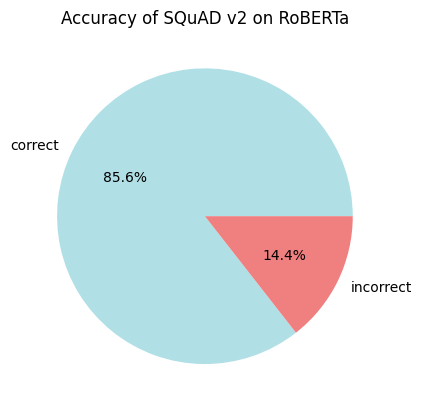

In [54]:
# general accuracy -> percentage of failure
labels = ['correct', 'incorrect']
values = [(num_total - num_failures), num_failures]

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=['powderblue', 'lightcoral'])
plt.title("Accuracy of SQuAD v2 on RoBERTa")
plt.show()

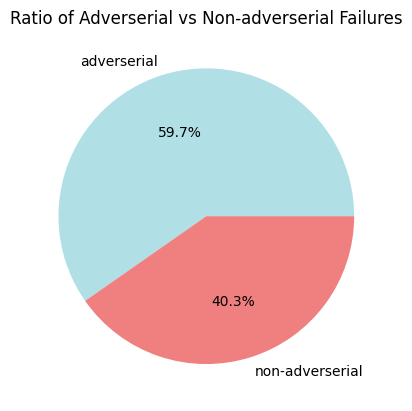

In [57]:
# ratio of adverserial vs non-adverserial in incorrect examples
labels = ['adverserial', 'non-adverserial']
values = [(num_incorrect_empty + (num_adverserial - num_correct_empty)), num_incorrect]

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=['powderblue', 'lightcoral'])
plt.title("Ratio of Adverserial vs Non-adverserial Failures")
plt.show()